In [1]:
import numpy as np
from sklearn.decomposition import PCA
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import os
import random
from random import shuffle
from skimage.transform import rotate
import scipy.ndimage
import scipy as sp
from scipy import fftpack
from sklearn.metrics import classification_report,accuracy_score,cohen_kappa_score,confusion_matrix
import pprint
import pandas as pd
from operator import truediv

In [19]:
import matplotlib.pyplot as plt

In [2]:
def loadIndianPinesData():
    data_path = os.path.join(os.getcwd(),'data')
    data = sio.loadmat("../../../Datasets/Indian_pines_corrected.mat")['indian_pines_corrected']
    labels = sio.loadmat("../../../Datasets/Indian_pines_gt.mat")['indian_pines_gt']
    
    return data, labels

In [3]:
def splitTrainTestSet(X, y, testRatio=0.10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=345,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [4]:

def dost_bw(l):
    out = np.zeros(int(2*np.log2(l)))
    l1 = np.arange(np.log2(l)-2,-1,-1)
    l2 = np.arange(0,np.log2(l)-1)
    out[1:int(1+np.log2(l)-1)]=l1
    out[-int(np.log2(l)-1):]=l2
    
    out = np.exp2(out).astype(np.int16)
    return out

def dost(inp):
    l = inp.shape[0]
    fft_inp = fftpack.fftshift(fftpack.fft(fftpack.ifftshift(inp,axes=0),axis=0),axes=0)
    #plt.figure(figsize = (30,5))
    #ax = np.linspace(-512,511,2**10)
    #plt.plot(ax,fft_inp[0,:])
    bw_inp = dost_bw(l)
#     print(bw_inp)
    k = 0
    dost_inp = np.zeros_like(fft_inp)

    for r in bw_inp:
        if(r==1):
            dost_inp[k,:] = fft_inp[k,:]
            k = k+r
        else:
            dost_inp[k:r+k,:] = fftpack.fftshift(fftpack.ifft(fftpack.ifftshift(fft_inp[k:r+k,:],axes=0),axis=0),axes=0)
            k = k+r

#     plt.plot(fft_inp)
    #plt.figure(figsize = (20,5))
    #plt.plot(np.abs(dost_inp[0,:]))
    
    
    return dost_inp
    

In [5]:
def oversampleWeakClasses(X, y):
    uniqueLabels, labelCounts = np.unique(y, return_counts=True)
    maxCount = np.max(labelCounts)
    labelInverseRatios = maxCount / labelCounts  
    # repeat for every label and concat
    newX = X[y == uniqueLabels[0], :, :, :].repeat(round(labelInverseRatios[0]), axis=0)
    newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
    for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        newX = np.concatenate((newX, cX))
        newY = np.concatenate((newY, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(newY.shape[0])
    newX = newX[rand_perm, :, :, :]
    newY = newY[rand_perm]
    return newX, newY


In [6]:
def standartizeData(X):
    newX = np.reshape(X, (-1, X.shape[2]))
    scaler = preprocessing.StandardScaler().fit(newX)  
    newX = scaler.transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1],X.shape[2]))
    return newX, scaler


In [7]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [8]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [9]:
def createPatches(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
#     patchIdx = []
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
#             patchIdx+=[[r,c]]
#     patchIdx = np.array(patchIdx,dtype=np.int32)
#     print(patchIdx.shape)
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
#         patchIdx = patchIdx[patchesLabels>0,:]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [10]:
def AugmentData(X_train):
    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):
            
            flipped_patch = np.flipud(patch)
        if (num == 1):
            
            flipped_patch = np.fliplr(patch)
        if (num == 2):
            
            no = random.randrange(-180,180,30)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),
                                                               reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)
    
    
    patch2 = flipped_patch
    X_train[i,:,:,:] = patch2
    
    return X_train

In [11]:
def savePreprocessedData(X_trainPatches, X_testPatches, y_trainPatches, y_testPatches, windowSize,dost_applied=False, wasPCAapplied = False, numPCAComponents = 0, testRatio = 0.25):
    if dost_applied:
        if wasPCAapplied:
            with open("../../data/XtrainWindowSize" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + "_dost.npy", 'wb+') as outfile:
                np.save(outfile, X_trainPatches)
            with open("../../data/XtestWindowSize" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + "_dost.npy", 'wb+') as outfile:
                np.save(outfile, X_testPatches)
            with open("../../data/ytrainWindowSize" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + "_dost.npy", 'wb+') as outfile:
                np.save(outfile, y_trainPatches)
            with open("../../data/ytestWindowSize" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + "_dost.npy", 'wb+') as outfile:
                np.save(outfile, y_testPatches)
        else:
            with open("../../data/XtrainWindowSize" + str(windowSize) + "_dost.npy", 'bw+') as outfile:
                np.save(outfile, X_trainPatches)
            with open("../../data/XtestWindowSize" + str(windowSize) + "_dost.npy", 'bw+') as outfile:
                np.save(outfile, X_testPatches)
            with open("../../data/ytrainWindowSize" + str(windowSize) + "_dost.npy", 'bw+') as outfile:
                np.save(outfile, y_trainPatches)
            with open("../../data/ytestWindowSize" + str(windowSize) + "_dost.npy", 'bw+') as outfile:
                np.save(outfile, y_testPatches)
    else:
        if wasPCAapplied:
            with open("../../data/XtrainWindowSize" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'wb+') as outfile:
                np.save(outfile, X_trainPatches)
            with open("../../data/XtestWindowSize" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'wb+') as outfile:
                np.save(outfile, X_testPatches)
            with open("../../data/ytrainWindowSize" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'wb+') as outfile:
                np.save(outfile, y_trainPatches)
            with open("../../data/ytestWindowSize" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'wb+') as outfile:
                np.save(outfile, y_testPatches)
        else:
            with open("../../data/XtrainWindowSize" + str(windowSize) + ".npy", 'bw+') as outfile:
                np.save(outfile, X_trainPatches)
            with open("../../data/XtestWindowSize" + str(windowSize) + ".npy", 'bw+') as outfile:
                np.save(outfile, X_testPatches)
            with open("../../data/ytrainWindowSize" + str(windowSize) + ".npy", 'bw+') as outfile:
                np.save(outfile, y_trainPatches)
            with open("../../data/ytestWindowSize" + str(windowSize) + ".npy", 'bw+') as outfile:
                np.save(outfile, y_testPatches)

In [29]:
# Global Variables
numComponents = 3
windowSize = 1
testRatio = 0.95

X, y = loadIndianPinesData()

In [30]:
X.shape

(145, 145, 200)

In [41]:
Xp,pca = applyPCA(X,numComponents=numComponents)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


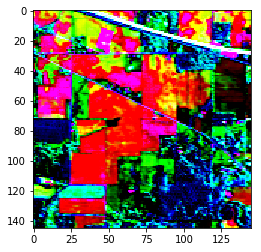

In [42]:
plt.imshow(Xp)

In [38]:
Xn = np.zeros([X.shape[0],X.shape[1],256])
Xn[:,:,:200]= X

Xnd = np.abs(dost(Xn.reshape([-1,Xn.shape[2]],order='F').T).T.reshape(Xn.shape,order='F'))

# Xnd=X
Xnp,pca = applyPCA(Xnd,numComponents=numComponents)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


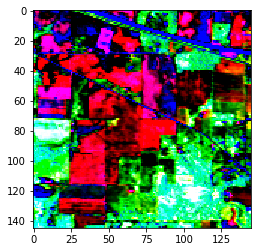

In [40]:
plt.imshow(Xnp)

In [44]:
plt.imsave('pca_3_dost.png',Xnp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [212]:
Xn = np.zeros([X.shape[0],X.shape[1],256])
Xn[:,:,:204]= X

Xnd = np.abs(dost(Xn.reshape([-1,Xn.shape[2]],order='F').T).T.reshape(Xn.shape,order='F'))

# Xnd=X
Xnp,pca = applyPCA(Xnd,numComponents=numComponents)
# Xnp = Xnd
# numComponents = Xnp.shape[2]
print(Xnp.shape)
XPatches, yPatches = createPatches(np.abs(Xnp), y, windowSize=windowSize)

# with open("../../data/XpatchesWindowSize" + str(windowSize) + "PCA" + str(numComponents) + "testRatio" + str(testRatio) + "_dost.npy", 'wb+') as outfile:
#     np.save(outfile, XPatches)
# with open("../../data/yPatchesWindowSize" + str(windowSize) + "PCA" + str(numComponents) + "testRatio" + str(testRatio) + "_dost.npy", 'wb+') as outfile:
#     np.save(outfile, yPatches)

X_train, X_test, y_train, y_test = splitTrainTestSet(XPatches, yPatches, testRatio)

X_train, y_train = oversampleWeakClasses(X_train, y_train)

# X_train = AugmentData(X_train)


# savePreprocessedData(X_train, X_test, y_train, y_test, windowSize = windowSize, 
#                      dost_applied=True,wasPCAapplied=True, numPCAComponents = numComponents,testRatio = testRatio)

from sklearn import svm

model = svm.SVC()


Xt = X_train.reshape((X_train.shape[0],-1))


model.fit(Xt,y_train)

Xtt = X_test.reshape((X_test.shape[0],-1))


predictions = model.predict(Xtt)


class_count = 16

results = classification_report(y_test,predictions,labels=range(0,class_count),output_dict=True)



def AA_andEachClassAccuracy(confusion_mat):
    """
        This function computes Average Accuracy and Classwise accuracy from confusion matrix

        confusion_matrix : Confusion matrix generated from the classification output

        returns each_acc, average_acc

        each_acc : An array of size class_count, each index conatining the accuracy of the corresponding class.
        average_acc :  Mean accuracy of class wise accuracy
    """
    counter = confusion_mat.shape[0]
    list_diag = np.diag(confusion_mat)
    list_raw_sum = np.sum(confusion_mat, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

confusion_mat = confusion_matrix(y_test,predictions)
accuracy = accuracy_score(y_test,predictions)
each_acc, average_acc = AA_andEachClassAccuracy(confusion_mat)
kappa = cohen_kappa_score(y_test,predictions)

(512, 217, 32)


C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [213]:
print(accuracy)
print(average_acc)
print(kappa)

pprint.pprint(each_acc)

0.8712443848083542
0.9370412023704072
0.8574149016255064
array([0.98795181, 0.99265537, 0.97336175, 0.9939577 , 0.96305031,
       0.99734113, 0.98970588, 0.56645185, 0.98778211, 0.92742453,
       0.92315271, 0.98907701, 0.96781609, 0.94094488, 0.82809558,
       0.96389051])


In [165]:
outputs = np.zeros((height,width))
for i in range(height-PATCH_SIZE+1):
    for j in range(width-PATCH_SIZE+1):
        target = int(y[i+PATCH_SIZE//2, j+PATCH_SIZE//2])
        if target == 0 :
            continue
        else :
#             image_patch=Patch(Xn,i,j)
            #print (image_patch.shape)
#             X_test_image = image_patch.reshape(1,image_patch.shape[2],image_patch.shape[0],image_patch.shape[1]).astype('float32')                                   
            prediction = (model.predict(Xn[i:i+1,j,:]))                         
            outputs[i+PATCH_SIZE//2][j+PATCH_SIZE//2] = prediction+1

In [167]:
import spectral

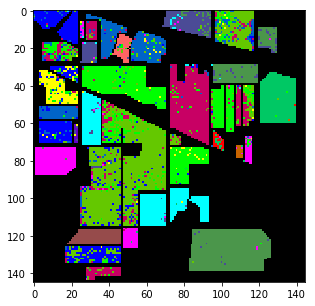

In [169]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))

In [216]:
import matplotlib.pyplot as plt

In [223]:
def class_to_color_mapper(cmap,class_count):
    """
        This function maps class labels to a particular color for displaying.

        cmap : classification map with labels
        class_count : number of classes

        returns y_map

        y_map : An RGB image based on cmap with a color assigned to each class
    """
    (m,n) = cmap.shape
    y_map = np.zeros((m,n,3))
    for item in range(class_count):
        if item == 0:
            y_map[cmap==(item+1)] = np.array([255, 0, 0]) / 255.
        if item == 1:
            y_map[cmap==(item+1)] = np.array([0, 255, 0]) / 255.
        if item == 2:
            y_map[cmap==(item+1)] = np.array([0, 0, 255]) / 255.
        if item == 3:
            y_map[cmap==(item+1)] = np.array([255, 255, 0]) / 255.
        if item == 4:
            y_map[cmap==(item+1)] = np.array([0, 255, 255]) / 255.
        if item == 5:
            y_map[cmap==(item+1)] = np.array([255, 0, 255]) / 255.
        if item == 6:
            y_map[cmap==(item+1)] = np.array([192, 192, 192]) / 255.
        if item == 7:
            y_map[cmap==(item+1)] = np.array([128, 128, 128]) / 255.
        if item == 8:
            y_map[cmap==(item+1)] = np.array([128, 0, 0]) / 255.
        if item == 9:
            y_map[cmap==(item+1)] = np.array([128, 128, 0]) / 255.
        if item == 10:
            y_map[cmap==(item+1)] = np.array([0, 128, 0]) / 255.
        if item == 11:
            y_map[cmap==(item+1)] = np.array([128, 0, 128]) / 255.
        if item == 12:
            y_map[cmap==(item+1)] = np.array([0, 128, 128]) / 255.
        if item == 13:
            y_map[cmap==(item+1)] = np.array([0, 0, 128]) / 255.
        if item == 14:
            y_map[cmap==(item+1)] = np.array([255, 165, 0]) / 255.
        if item == 15:
            y_map[cmap==(item+1)] = np.array([255, 215, 0]) / 255.

    return y_map

def classification_map(map, dpi, figpath):
    """
        This function plots the classification map

        map : RGB image of classification map
        dpi : to control the size of the image generated
        figpath : location where the image is saved
    """
    fig = plt.figure(frameon=False)
    fig.set_size_inches(map.shape[1]*1.0/dpi, map.shape[0]*1.0/dpi)

    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.add_axes(ax)

    ax.imshow(map)
    fig.savefig(figpath, dpi = dpi)

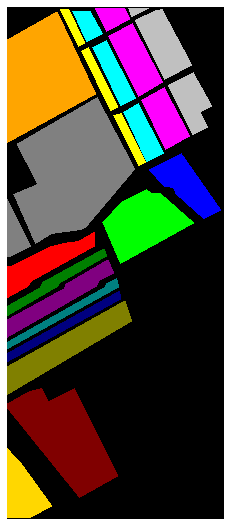

In [224]:
classification_map(class_to_color_mapper(y,16),72,"salinas_gt.png")

In [227]:
np.sum(y==0)+np.sum(y!=0)

111104

In [228]:
512*217

111104